# Project - linear separability in data


The objective of the project is to analyse the "Speaker Accent Recognition Dataset" from the UCI Machine Learning Repository. The task is to determine if the dataset is linearly separable in the feature space defined by the linear Principal Component Analysis (PCA) or in the feature space defined by the non-linear PCA with the use of the Radial Basis Function Kernel. 

## Part A - Data visualization
Part A of the project focuses on visualizing the data in the 2-D feature space defined by the top 2 linear principal components based on SVD.

In [1]:
#Import the libraries required for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.utils import io
%matplotlib inline

In [2]:
#setting the random seed for the notebook reproducibility 
np.random.seed(111)

In [3]:
#reading the dataset as a dataframe
data = pd.read_csv("C:\\Users\\spzvl\\Downloads\\accent-mfcc-data-1.data", header = None)

In [4]:
#displaying the first 5 rows of the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,ES,7.071476,-6.512900,7.650800,11.150783,-7.657312,12.484021,-11.709772,3.426596,1.462715,-2.812753,0.866538,-5.244274
1,ES,10.982967,-5.157445,3.952060,11.529381,-7.638047,12.136098,-12.036247,3.491943,0.595441,-4.508811,2.332147,-6.221857
2,ES,7.827108,-5.477472,7.816257,9.187592,-7.172511,11.715299,-13.847214,4.574075,-1.687559,-7.204041,-0.011847,-6.463144
3,ES,6.744083,-5.688920,6.546789,9.000183,-6.924963,11.710766,-12.374388,6.169879,-0.544747,-6.019237,1.358559,-6.356441
4,ES,5.836843,-5.326557,7.472265,8.847440,-6.773244,12.677218,-12.315061,4.416344,0.193500,-3.644812,2.151239,-6.816310


In [5]:
X = data.iloc[:,1:]
labels = data[0]

In [6]:
#The single value decomposition function. Takes in the feature vectors and the number of PC wanted.
def SVD(X, num_pc = 2):
    #centering the features
    X = X.apply(lambda x: x-x.mean())
    
    #Perform SVD using numpy
    U, S, V = np.linalg.svd(X, full_matrices = True)
    #Return the top 2 required principal components
    return V[0: num_pc,]

In [7]:
#Execute the SVD function and perform the change of basis.
TopPC = SVD(X)
changeBasis = np.dot(X, TopPC.T)
#Add the ground truth labels to the new dataset
df_changeBasis = pd.DataFrame(changeBasis)
df_changeBasis["label"] = labels

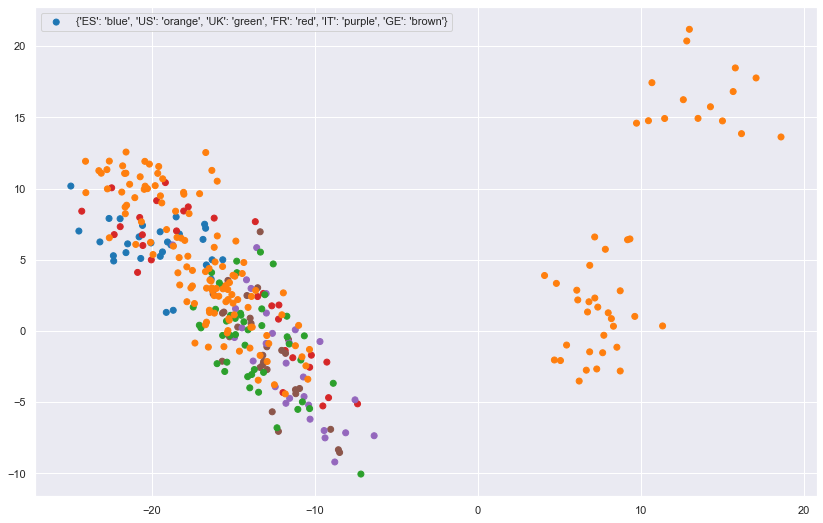

In [8]:
#Visualising the 2-D feature space.
colors = {'ES':'tab:blue', 'US':'tab:orange', 'UK':'tab:green', 'FR':'tab:red', 'IT':'tab:purple', 'GE':'tab:brown'}
labels = {'ES':'blue', 'US':'orange', 'UK':'green', 'FR':'red', 'IT':'purple', 'GE':'brown'}
#Utilising the seaborn easthetics and setting an appropriate figure size
sns.set(rc={'figure.figsize':(14,9)})
#instantiating the scatter plot
plt.scatter(df_changeBasis[0], df_changeBasis[1], c = df_changeBasis["label"].map(colors), label = labels )
plt.legend()

The plot showing the dataset in the 2-D feature space defined by the Principal Components.

From the visual analysis of the plot, it is clear that the dataset is not linearly separable in this feature space, since we cannot plot straight line(s) separating the points into distinct clusters.
There are points belonging to the US label (orange) that are located further away along the x-axis and the y-axis from the rest of the dataset, however other points from the US label are mixed with the rest of the accents. Furthermore, other accent labels are located close to each other, forming no obvious groups. 


## Part B - Determining if the dataset is linearly separable
  Part B of the project is further split into 3 parts:
- B1 is concerned with checking linear separability in the original feature space
- B2 is focused on detecting linear separability in the feature space defined by linear PCA
- B3 implements non-linear PCA with all possible feature vectors to identify separability.

The following is the implementation of the binary perceptron, which will be used in Part B of the project.

In [9]:
#The implementation of Binary perceptron. Takes in the feature vectors, the label (accent), and the
#number of maximum allowed algorithm iterations is specified.
def PerceptronBinary(X,y_true, label, max_iter = 10):
    initMaxIter = max_iter
    #creating an empty weight vector
    w = np.zeros((len(X.T),1)).flatten()
    
    err = 1
    #loop continues until error is 0 or until reached the max number of iterations
    while  max_iter <=initMaxIter and err != 0:
        err = 0
        #The alternative for one hot encoding. This does not permanently encode the features.
        #It simplifies the implementation of multi-class perceptron. 
        #If the current label (accent) matches the ground truth, label it as 1 and -1 otherwise.
        for i in range(len(X)):
            if y_true.iloc[i] == label:
                y = 1
            else:
                y=-1
                
            #the observed error is calculated
            e_obs = np.sign(np.matmul(w,X.iloc[i])) - y
            #if the error is not 0, update the weights.
            if e_obs !=0:
                err = 1
                w += y * X.iloc[i]
        #increase the loop while loop iteration counter.        
        print("while loop iteration: ", max_iter)        
        max_iter+=1
        #print(w)

    #returns the trained weights.                    
    return w    

The softmax function will also be utilised in part B of the project

In [10]:
#The softMax helper function is used by the multi-class perceptron. It forces the highest
#score classifier to be the correct one.
#It takes in the dictionary of accents(keys) and trained weights(values). It outputs the dictionary
#with softmax applied to it.
def softMaxLoss(dictionary):
    l = []
    for i in dictionary:
        l.append(dictionary[i])
        
    arr = np.array(l) 
    sm = (np.exp(arr-np.max(arr)))
    res_arr = sm/sm.sum(axis=0)
    res_dictionary = {}
    j = 0
    for i in dictionary:
        res_dictionary[i] = res_arr[j]
        j+=1
    
    return res_dictionary

### Part B1

The implementation of the multi-class perceptron. It works by training binary perceptrons, such that binary perceptron c outputs the score associated with the confidence that sample i belongs to class c (with softmax applied to it). Consequently, the label of the binary perceptron with the highest probability is selected as the predicted label.

In [11]:
#The function take in the whole dataset and the maximum allowed number of iterations. 
def MultiClass(data, iterations = 10):
    
    #creating a bias which will be added to the feature vectors
    bias = pd.DataFrame(np.ones((len(data),1)), columns = ["bias"])
    #defining a dictionary of weights
    weights = {}
    
    #loop over all possible accents
    for i in data[0].unique():
        #re-shuffle the dataset as required
        data = data.sample(frac=1, random_state=111).reset_index(drop=True)
        #select the feature vectors
        X = data.iloc[:,1:]
        #add the bias to the feature vectors
        X = pd.merge(X, bias, left_index=True, right_index = True)
        #train the weights associated with each accent.
        weights[i] = PerceptronBinary(X, data[0], i, max_iter = iterations)
        
    #define a dataframe used for comparing the predictions to ground truth.
    pred_labels = pd.DataFrame(columns=["label"])
    
    #loop through each sample of the dataset. Calculate the scores for each sample by multiplying the
    #trained weights by the feature vectors and store them in a temporary dictionary.
    for i in range(len(data)):
        temp = {}
        for j in data[0].unique():
            temp[j] = np.dot(weights[j], X.iloc[i].T)

        #apply softmax to the scores
        temp = softMaxLoss(temp)
        #take the highest score label and place it in the dataframe storing the predicted labels.
        pred_labels.loc[len(pred_labels)] = [max(temp, key = temp.get)]
        
    #counter of the number of correctly predicted labels.    
    corr = 0
    
    #error breakdown for future analysis.
    print("breakdown of predicted values: ")
    print(pred_labels["label"].value_counts())
    print("breakdown of actual values: ")
    print(data[0].value_counts())
    
    #calculating the accuracy score.
    for i in range(len(pred_labels)):
        if pred_labels["label"][i] == data[0][i]:
            corr +=1
    acc = corr/len(pred_labels)
    
    #return the accuracy.
    print("Accuracy: ")
    return acc

In [12]:
MultiClass(data)

while loop iteration:  10
while loop iteration:  10
while loop iteration:  10
while loop iteration:  10
while loop iteration:  10
while loop iteration:  10
breakdown of predicted values: 
US    129
FR     83
IT     49
GE     38
UK     17
ES     13
Name: label, dtype: int64
breakdown of actual values: 
US    165
UK     45
GE     30
IT     30
FR     30
ES     29
Name: 0, dtype: int64
Accuracy: 


0.5805471124620061

From the output of the multi-class perceptron shown above, it can be deduced that the dataset is not linearly separable in its original feature space. This is because the accuracy of the perceptron does not achieve a value close to 100% when predicting the accent. When a dataset is linearly separable in a given feature space, the single layer perceptron implementation trained and tested on the whole dataset will achieve accuracy close to 100%.

### Part B2

The following function implements the multi-class perceptron on the feature spaces defined by linear PCA. It is then tested by a small gridsearch, and the accuracy is visualised.

In [13]:
#Inputs are the dataset, the maximum number of iterations and the number of PC that should be used.
def MultiClassPC(data, iterations = 10, num_pc = 3):
    
    #creating bias that will be added to the data
    bias = pd.DataFrame(np.ones((len(data),1)), columns = ["bias"])
    #re-shuffle the dataset following the requirements.
    data = data.sample(frac=1, random_state=111).reset_index(drop=True)
    #add the bias to the dataset
    data = pd.merge(data, bias, left_index=True, right_index = True)
    
    #extract the feature vectors with the bias.
    X = data.iloc[:,1:]
    #re-use the SVD function defined earlier to calculate the required number of principal components.
    X_pc = SVD(X, num_pc = num_pc)
    pc_cols = []
    for i in range(1, num_pc+1):
        pc_cols.append(i)
    #store the principal components in a dataframe.        
    X = pd.DataFrame(columns = pc_cols, data = X_pc.T)
    print(X)
    weights = {}
    for i in data[0].unique():
        #train the weights in the space defined by the principal components.
        weights[i] = PerceptronBinary(X, data[0], i, max_iter = iterations)
        
    #create a dataframe for storing the predicted labels.
    pred_labels = pd.DataFrame(columns=["label"])
    #Multiply te data by the principal components to perform the change of basis.
    x_arr = np.array(data.iloc[:,1:].values.tolist())
    x_arr = np.dot(x_arr, X_pc.T)
    
   #loop through each sample of the dataset. Calculate the scores for each sample by multiplying the
    #trained weights by the feature vectors and store them in a temporary dictionary.
    for i in range(len(data)):
        temp = {}
        for j in data[0].unique():
            temp[j] = np.dot(weights[j], x_arr.T)[i]
        print(temp)
        #apply softmax to the scores
        temp = softMaxLoss(temp)
        #take the highest score label and place it in the dataframe storing the predicted labels.
        pred_labels.loc[len(pred_labels)] = [max(temp, key = temp.get)]
        
    #counter of the number of correctly predicted labels.         
    corr = 0
    
    #error breakdown for future analysis.
    print("breakdown of predicted values: ")
    print(pred_labels["label"].value_counts())
    print("breakdown of actual values: ")
    print(data[0].value_counts())
    
    #calculating the accuracy score.
    for i in range(len(pred_labels)):
        if pred_labels["label"][i] == data[0][i]:
            corr +=1
    acc = corr/len(pred_labels)
    
    #return the accuracy
    return acc

In [14]:
#Function performs a small grid search for illustrative purposes only. Coveres the range of the PCs
#and calculates the accuracy of multi-class perceptron with a certain number of PCs used.
def GridSearch(num_pc_range, data):
    #ignoring the print statements to make the output more concise 
    with io.capture_output() as captured:
        #create a dataframe storing the grid search results
        results = pd.DataFrame(columns = ["Accuracy", "Num_PC"])
        #loop through the range of principal components
        for i in num_pc_range:
            #calculate the accuracy and store the results in the dataframe.
            acc = MultiClassPC(data, num_pc = i, iterations = 10)
            results.loc[len(results)] = [acc, i]
        #visualise the resulting dataframe.    
        sns.color_palette("Spectral", as_cmap=True)        
        sns.lineplot(data = results, y = "Accuracy", x = "Num_PC") 

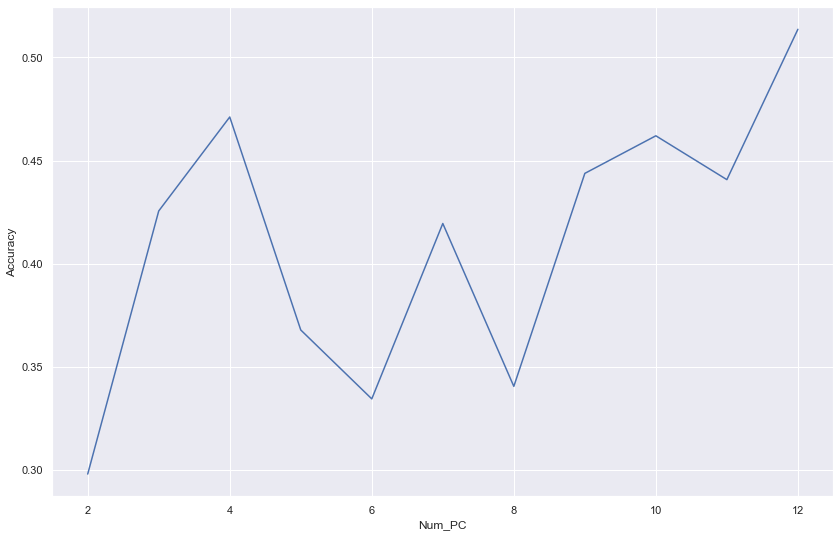

In [15]:
#Using Seaborn aesthetics, set the appropriate figure size, and execute the grid search. 
sns.set(rc={'figure.figsize':(14,9)})
pc_range = [2,3,4,5,6,7,8,9,10,11,12]
GridSearch(pc_range,  data)

The plot above shows the performance of the multi-class perceptron in all possible feature spaces defined by linear PCA.

The plot indicates a general upward trend in terms of the prediction accuracy as the number of principal components used increases. There are 2 significant reductions in accuracy when 6 and 8 principal components are used. This can be attributed to random chance, since the data was shuffled at each iteration and the order of data on which the perceptron is trained can greatly affect the accuracy of prediction. This can be explained by the logic behind the perceptron algorithm, which is forced to stop executing when it is no longer making errors, potentially causing it to find local minimums and preventing it from finding the optimal solution.  
It is evident that the dataset is not linearly separable in this case as well, since the accuracy of prediction remains far from 100% even when all 12 principal components are utilised.

### Part B3

The following function creates the RBF kernel and normalises it. It follows the formula of the RBF kernel: k(xi, xj) = exp(-lam||xi-xj||^2)

In [16]:
#Inputs are the dataset and the value of sigma.
#Sigma is 1 by default, will be updated using the functions below.
def kernelRBF(data, sig = 1):
    #specify the lambda
    lam = 1/(2*sig**2)
    #extract the feature vectors
    X = data.iloc[:,1:]
    #Define the normalisation matrix.
    A_vals =  len(X)
    A = np.full((A_vals,A_vals), (1/A_vals))
    #define the size of kernel.
    kernel = np.zeros((len(data),len(data)))
    #loop through the data to create the RBF kernel.
    for i in range(len(X)):
        for j in range(len(X)):
            
            val = np.exp(-lam*((np.linalg.norm(X.iloc[i,:] - X.iloc[j,:]))**2))
            kernel[i][j] = val
    #normalize the kernel.
    normalized_kernel = kernel - np.matmul(A,kernel) - np.matmul(kernel,A) + np.matmul(np.matmul(A,kernel),A)
    print("Kernel created and normalized")
    print("Kernel shape: ", kernel.shape)
    #returns the kernel 
    return pd.DataFrame(normalized_kernel), lam

The following function is the implementation of multi-class perceptron on the data mapped to a very high dimensional feature space by the RBF kernel.

In [17]:
#The inputs are the original data, the data mapped by the kernel, the max number of iterations,
#the dimensionality of the feature vectors, and sigma.
def multiClassPerceptronKernel(data, kernel_data, iterations = 10 , num_pc=329, sig = 1):
    #the computed mapping is reduced to the required size.
    data_rbf = kernel_data.iloc[:,:num_pc]

    #weight dictionary defined
    weights = {}
    #loop through all of the accent labels
    for i in data[0].unique():
        #train the weights on the mapped data.
        weights[i] = PerceptronBinary(data_rbf, data[0], i, max_iter = iterations)
    #create a dataframe to store the predicted labels.
    pred_labels = pd.DataFrame(columns=["label"])
        
    
    
    #loop through every data sample, and multiply the trained weights by the kernel data.
    for i in range(len(data)):
        temp = {}
        for j in data[0].unique():
            temp[j] = np.dot(weights[j], data_rbf.T)[i]
        #utilise the softmax function 
        temp = softMaxLoss(temp)
        
        #record the highest value labels as the predicted labels.
        pred_labels.loc[len(pred_labels)] = [max(temp, key = temp.get)]
    #instantiate the correct label counter    
    corr = 0
    #break down of the errors
    print("breakdown of predicted values: ")
    print(pred_labels["label"].value_counts())
    print("breakdown of actual values: ")
    print(data[0].value_counts())
    #calculate the accuracy
    for i in range(len(pred_labels)):
        if pred_labels["label"][i] == data[0][i]:
            corr +=1
    acc = corr/len(pred_labels)
    print("accuracy: ", acc)
    #output the accuracy
    return acc

The function defined below was not used in the final grid search. This is because the lambda range specified by the function is too large, and the run time of the grid search is too long.

In [18]:
#The function identifies the required sigma range for the grid search. The produced results are
#later used to calculate the lambda range.
def FindSigmaRange(data):
    var_range = []
    #extract the feature vectors, and center them.
    data = data.iloc[:,1:]
    data = data.apply(lambda x: x-x.mean())
    X = data.to_numpy()
    #find the min and max variance and return it.
    var = np.var(X, axis = 1)
    var_range.append(var.max())
    var_range.append(var.min())
    return var_range

The following function implements the grid search, in order to find the optimal sigma value (which is used to find lambda utilsed in the RBF kernel mapping) and the minimum dimensionality required in order to achieve separability in the dataset.

In [33]:
#The function inputs are the dataset, the list containing min and max values of sigma to be used, 
#and the lower bound of the dimensionality.
def KernelGridSearch(data, sigma_minmax, dim_range):
    #the small constant to cover the full range of values
    epsilon = 0.05
    #the grid search results will be stored as a dataframe
    results = pd.DataFrame(columns = ["Accuracy", "dimension", "lambda"])
    #The list of sigma values which need to be tested is generated by starting with the min value
    #and incrementing the sigma, until the maximum is achieved.
    sigma_range = []
    v = sigma_minmax[1]-epsilon
    while v <= sigma_minmax[0]+epsilon:
        sigma_range.append(v)
        v+=0.079
     #The 2 nested for loops perform the grid search. It takes a while for the function to execute,
    #so it has been optimised to run faster. In particular, the kernel is calculated for a specific
    #value of sigma and then is cropped inside the second for loop to reducee the dimensionality.
    
    #loop through the sigma range
    for i in sigma_range:
        #calculate the lambda when a particular sigma is used, and return its value along 
        #with the mapped data
        kernel_data, lam = kernelRBF(data, sig = i)
        #Vary the number of dimensions
        for j in dim_range:
            with io.capture_output() as captured:
                acc = multiClassPerceptronKernel(data, kernel_data, num_pc = j, sig = i)
                results.loc[len(results)] = [acc, j, lam]
    #output the results            
    return results     

In [34]:
#Executing the grid search. The function takes a long time to exhaustively loop through all of the
#parameter spaces, even after some optimisation.
sigma_minmax = [1.11, 0.32]
dim_range = list(range(150, 166))
plotting_data = KernelGridSearch(data, sigma_minmax, dim_range)

Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)
Kernel created and normalized
Kernel shape:  (329, 329)


In [35]:
#the resulting dataframe
plotting_data

,Accuracy,dimension,lambda
0,0.957447,150.0,6.858711
1,0.960486,151.0,6.858711
2,0.963526,152.0,6.858711
3,0.966565,153.0,6.858711
4,0.969605,154.0,6.858711
...,...,...,...
187,0.987842,161.0,0.385410
188,0.990881,162.0,0.385410
189,0.993921,163.0,0.385410
190,0.996960,164.0,0.385410


In [36]:
plt_data = plotting_data.copy()

In [37]:
#rounding the values to make the plot more clear.
plt_data = plt_data.round(3)

<AxesSubplot:xlabel='lambda', ylabel='dimension'>

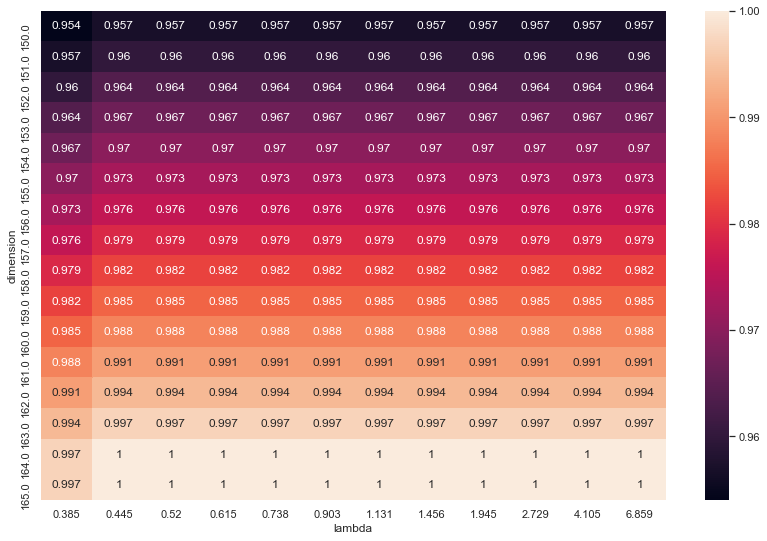

In [42]:
pivot = plt_data.pivot(index = "dimension", columns = "lambda", values = "Accuracy" )
sns.heatmap(pivot, annot = True, fmt="g")

The plot above is a heatmap showing the prediction accuracy of the multi-class perceptron in the feature space defined by the RBF kernel. The x-axis of the map shows the range of lambda values covered by the grid search, and the y-axis shows a subset of the dimensionality of the kernel.

From the heatmap, it is evident that the lowest dimensionality of the new feature vectors that lead to separability is 164. Furthermore, the lowest lambda value that leads to separability is 0.445 

Since it is possible to achieve 100% prediction accuracy with a certain number of feature vectors, the dataset is separable in the feature space defined by non-linear PCA. 

